In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import re
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.linear_model import LinearRegression

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_field_metrics
import configs

device = 'cpu'

# Collect metrics over datasets
You will have to run the corresponding python file to this jupyter notebook (will have the same title, but with 'parfor' attached).

In [96]:
gamma = 0.75
model = 'rnn_oja'

In [97]:
root_dir = '/home/chingf/engram/Ching/03_td_discrete_corr/'
with open(f'{root_dir}5a_{model}_results_gamma{gamma}.p', 'rb') as f:
    results = pickle.load(f)

In [98]:
results.keys()

dict_keys(['gamma', 'arena_length', 'init_sparsities', 'sigmas', 'final_sparsities', 'fieldsizes', 'nfields', 'onefields', 'zerofields', 'fieldsizekls', 'nfieldkls'])

In [99]:
arena_length = np.array(results['arena_length'])
init_sparsities = np.array(results['init_sparsities'])
sigmas = np.array(results['sigmas'])
final_sparsities = np.array(results['final_sparsities'])
final_sparsities = np.around(final_sparsities, decimals=2)
fieldsizes = np.array(results['fieldsizes'])
nfields = np.array(results['nfields'])
onefields = np.array(results['onefields'])
zerofields = np.array(results['zerofields'])
fieldsizekls = np.array(results['fieldsizekls'])
nfieldkls = np.array(results['nfieldkls'])

In [100]:
df = pd.DataFrame({
    'Seed Sparsity': init_sparsities,
    'Spatial Corr.': sigmas,
    'Sparsity': final_sparsities,
    'Field Size': fieldsizes,
    'Fields per Neuron': nfields,
    'Single Field Neurons': onefields,
    'Zero Field Neurons': zerofields,
    'Field Sizes KL': fieldsizekls,
    'N Fields KL': nfieldkls
    })

# Make gradient plots

In [101]:
def make_gradients(
    xs, ys, zs, cmap="Reds", interpolate=False,
    title=None, xlabel=None, ylabel=None, figname=None,
    smooth=False, contourz=None, figsize=[6.4, 4.8]
    ):
    
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dx = x_list[1:] - x_list[:-1]
    dy = y_list[1:] - y_list[:-1]
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            idx = np.logical_and(
                xs==x[i,j], ys==y[i,j]
                )
            z[i,j] = np.nanmean(zs[idx])

    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots()
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    im = ax.pcolormesh(x, y, z, cmap=cmap)
    fig.colorbar(im, ax=ax)
    ax.set_title('pcolormesh with levels')
    plt.show()
    
    plt.figure()
    plt.imshow(z)
    plt.colorbar()
    plt.show()
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    #levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    
    # contours are *point* based plots, so convert our bound into point
    # centers
    fig, ax = plt.subplots(figsize=figsize)
    cf = ax.contourf(x,#[:-1, :-1] + dx/2.,
                     y,#[:-1, :-1] + dy/2.,
                     z, levels=levels, cmap=cmap
                     )
    if contourz is not None:
        cntrs = plt.contour(
            x, y, contourz, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
            colors='white'#'dimgray'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


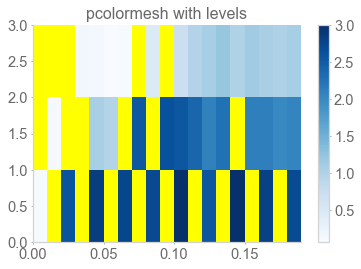

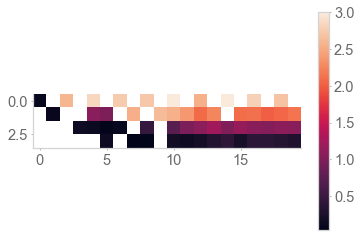

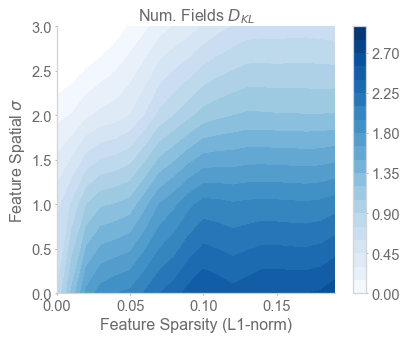

In [102]:
_x, _y, _z = make_gradients(
    final_sparsities, sigmas,
    np.clip(nfieldkls, 0, 3),
    cmap='Blues',
    title='Num. Fields $D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_nfieldkls_gamma{gamma}',
    interpolate=True, smooth=True, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


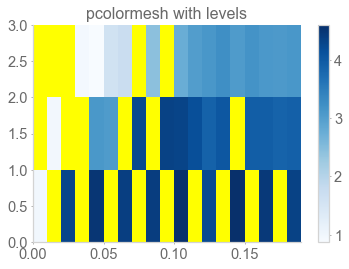

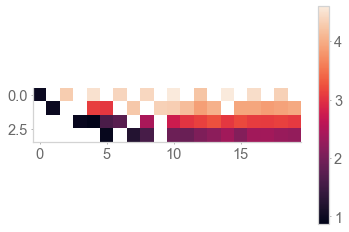

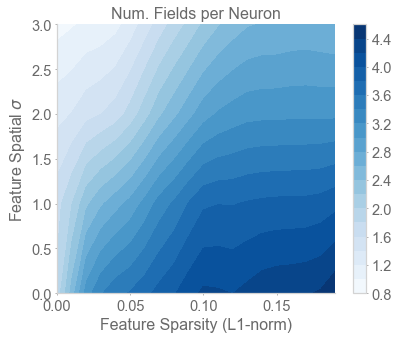

In [103]:
_, _, _ = make_gradients(
    final_sparsities, sigmas, nfields, cmap='Blues',
    title='Num. Fields per Neuron',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_nfields_gamma{gamma}',
    interpolate=True, smooth=True, figsize=[6,5],# contourz=_z
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


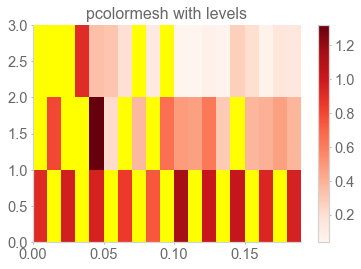

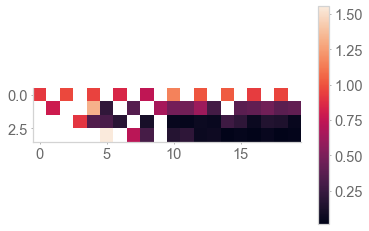

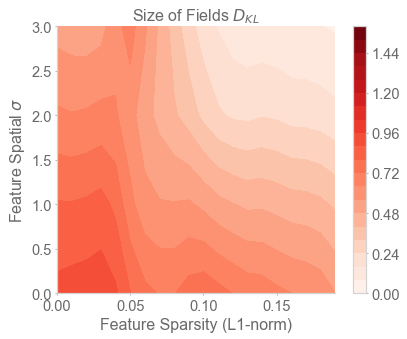

In [104]:
_x, _y, _z = make_gradients(
    final_sparsities, sigmas,
    np.clip(fieldsizekls, 0, 3),
    cmap='Reds',
    title='Size of Fields $D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_fieldsizekls_gamma{gamma}',
    interpolate=True, smooth=True, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


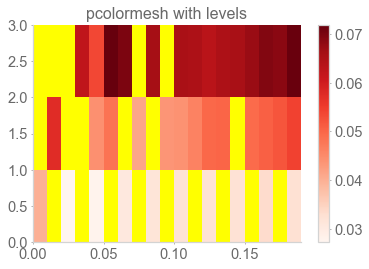

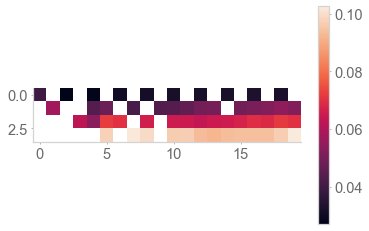

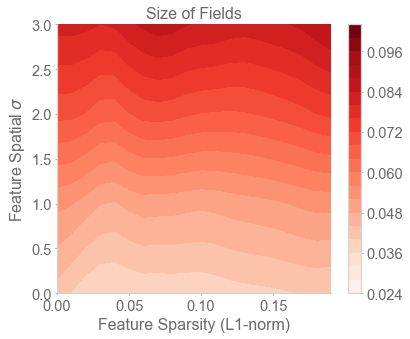

In [105]:
_,_,_ = make_gradients(
    final_sparsities, sigmas, fieldsizes, cmap='Reds',
    title='Size of Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_fieldsizes_gamma{gamma}',
    interpolate=True, smooth=True, figsize=[6,5]#, contourz=_z
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Purples").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


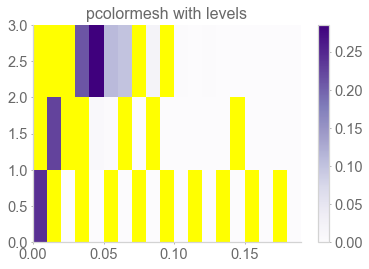

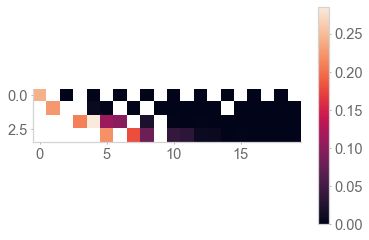

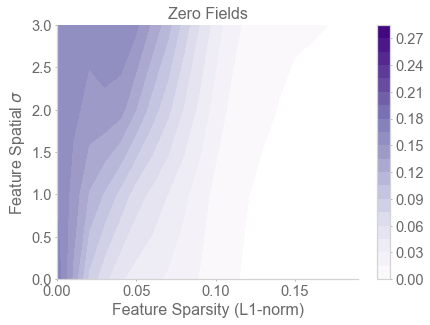

In [106]:
_, _, _ = make_gradients(
    final_sparsities, sigmas, zerofields, cmap='Purples',
    title='Zero Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_zerofields_gamma{gamma}',
    interpolate=True, smooth=True
    )

# Make dataset divergence gradient plots

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


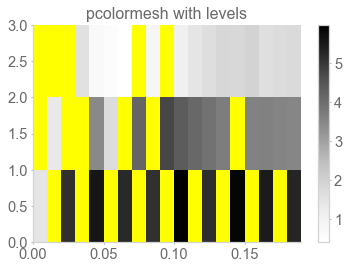

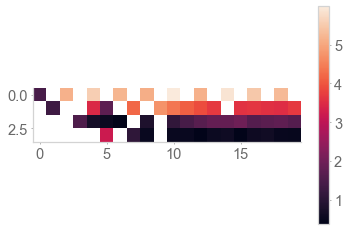

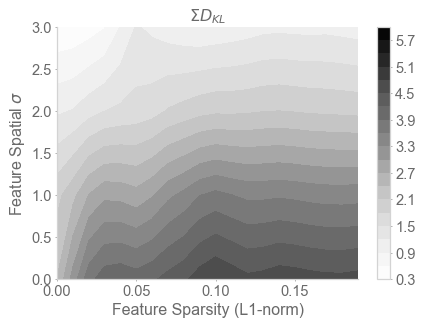

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


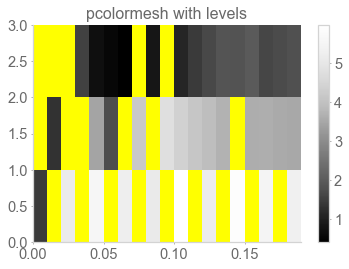

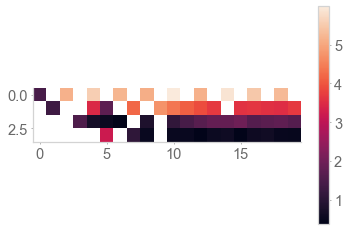

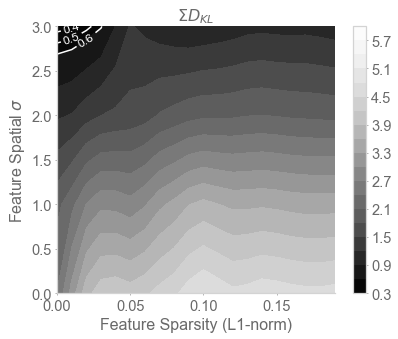

In [107]:
log2_e = 1.442695
clip_max = 7.0
nats_to_bits = lambda x: log2_e*x
aggregate_kls = nats_to_bits(fieldsizekls) + nats_to_bits(nfieldkls)
_,_, _z = make_gradients(
    final_sparsities, sigmas,
    np.clip(aggregate_kls, 0, clip_max),
    cmap='Greys',
    title='$\Sigma D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_sumkls_gamma{gamma}',
    interpolate=True, smooth=True
    )
_,_, _z = make_gradients(
    final_sparsities, sigmas,
    np.clip(aggregate_kls, 0, clip_max),
    cmap='Greys_r',
    title='$\Sigma D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_sumkls_gamma{gamma}',
    interpolate=True, smooth=True, contourz=_z, figsize=[6,5]
    )

In [88]:
np.sort(np.unique(init_sparsities))

array([0.001     , 0.00344444, 0.00533333, 0.00588889, 0.00833333,
       0.00966667, 0.01077778, 0.012     , 0.01322222, 0.014     ,
       0.01566667, 0.01811111, 0.01833333, 0.02055556, 0.02088889,
       0.02266667, 0.023     , 0.023     , 0.027     , 0.03133333,
       0.034     , 0.03566667, 0.04      , 0.04077778, 0.045     ,
       0.056     , 0.06066667, 0.067     , 0.078     , 0.08055556,
       0.089     , 0.1       , 0.10044444, 0.12033333, 0.14022222,
       0.16011111, 0.18      ])